## КУРСОВОЙ ПРОЕКТ

в двух частях (обработка "сырых" данных и работа с данными)
#### По курсу: Теория вероятностей и математическая статистика

#### Студент: Иванов А.Л. 

Необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяют качество продукции, производимое на обжиговой машине.
Обжиговая машина представляет собой агрегат, состоящий из 5 одинаковых по размеру камер, в каждой камере установлено по 3 датчика температур. Кроме этого, для данной задачи Вы собрали данные о высоте слоя сырья и его влажности. Высота слоя и влажность измеряются при входе сырья в машину. Сырье проходит через обжиговую машину за час.
Название тега	Описание тега
* **T_data_1_1** - 1-й датчик в 1-й камере
* **T_data_1_2** - 2-й датчик в 1-й камере
* **T_data_1_3** -	3-й датчик в 1-й камере
* **T_data_2_1** -	1-й датчик во 2-й камере
* **T_data_2_2** -	2-й датчик во 2-й камере
* **T_data_2_3** -	3-й датчик во 2-й камере
* **T_data_3_1** -	1-й датчик в 3-й камере
* **T_data_3_2** -	2-й датчик в 3-й камере
* **T_data_3_3** -	3-й датчик в 3-й камере
* **T_data_4_1** -	1-й датчик в 4-й камере
* **T_data_4_2** -	2-й датчик в 4-й камере
* **T_data_4_3** -	3-й датчик в 4-й камере
* **T_data_5_1** -	1-й датчик в 5-й камере
* **T_data_5_2** -	2-й датчик в 5-й камере
* **T_data_5_3** -	3-й датчик в 5-й камере
* **H_data**     - Высота слоя 
* **AH_data**    -	Влажность сырья

Данные с показателями работы обжиговой машины содержатся в файле X_data.csv:
Качество продукции измеряется в лаборатории по пробам, которые забираются каждый час, данные по известным анализам содержатся в файле Y_train.csv. В файле указано время забора пробы, проба забирается на выходе из обжиговой машины.
Оценкой модели будет являться показатель MAE модели на тестовых данных.


## Часть 1. Обработка "сырых" данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy.stats import norm
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option("display.precision", 3)
#pd.set_option('max_colwidth', 100)
pd.set_option('display.width', 500)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 25)
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [3]:
df = pd.read_csv('data/row/X_data.csv', sep=';')

In [4]:
df.sample()

,Unnamed: 0,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
44209,31.01.2015 16:49,253,263,262,367,361,353,506,509,465,356,222,341,262,259,259,194.11,7.90


In [5]:
df.rename(columns={'Unnamed: 0': 'OpTime'}, inplace=True)  # переименуем столбец даты

In [6]:
df['OpTime'] = pd.to_datetime(df['OpTime'], dayfirst=True)  # приведем тип к дате

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
OpTime        1048575 non-null datetime64[ns]
T_data_1_1    1048575 non-null int64
T_data_1_2    1048575 non-null int64
T_data_1_3    1048575 non-null int64
T_data_2_1    1048575 non-null int64
T_data_2_2    1048575 non-null int64
T_data_2_3    1048575 non-null int64
T_data_3_1    1048575 non-null int64
T_data_3_2    1048575 non-null int64
T_data_3_3    1048575 non-null int64
T_data_4_1    1048575 non-null int64
T_data_4_2    1048575 non-null int64
T_data_4_3    1048575 non-null int64
T_data_5_1    1048575 non-null int64
T_data_5_2    1048575 non-null int64
T_data_5_3    1048575 non-null int64
H_data        1048575 non-null float64
AH_data       1048575 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(15)
memory usage: 144.0 MB


##### К структуре данных замечаний нет

In [8]:
df_copy = df.copy() # Сохраним в памяти копию данных

In [9]:
df

,OpTime,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2016-12-29 04:10:00,228,271,267,364,363,362,592,576,588,355,388,509,247,241,248,190.37,7.13
1048571,2016-12-29 04:11:00,228,270,267,363,363,363,592,577,588,354,389,514,247,242,248,195.29,7.13
1048572,2016-12-29 04:12:00,228,270,267,363,362,363,593,577,588,353,389,518,247,242,248,193.12,7.13
1048573,2016-12-29 04:13:00,228,270,267,363,362,364,594,577,588,353,390,523,247,242,248,190.67,7.13


In [10]:
df.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00
mean,250.84,250.36,250.81,349.89,349.92,349.69,501.52,501.51,501.84,349.42,349.42,350.24,249.57,249.74,249.70,174.54,7.50
std,31.26,30.17,30.75,44.28,40.83,37.22,60.11,67.03,62.08,38.84,38.78,40.85,30.81,30.34,29.72,14.42,1.14
min,-159.00,-122.00,-107.00,-703.00,-766.00,-191.00,-317.00,-759.00,-449.00,-152.00,-471.00,-609.00,-89.00,-125.00,-130.00,141.49,3.12
25%,229.00,229.00,230.00,328.00,328.00,328.00,465.00,465.00,465.00,327.00,328.00,328.00,229.00,229.00,229.00,162.31,6.74
50%,251.00,251.00,251.00,350.00,350.00,350.00,502.00,502.00,502.00,350.00,350.00,350.00,249.00,250.00,250.00,174.31,7.52
75%,272.00,272.00,272.00,372.00,373.00,372.00,538.00,538.00,539.00,372.00,371.00,372.00,270.00,270.00,270.00,186.66,8.27
max,673.00,552.00,551.00,1009.00,1179.00,876.00,1434.00,2505.00,1319.00,912.00,741.00,798.00,905.00,738.00,538.00,207.74,11.60


##### Есть значения температуры, которые находятся вне разумных пределов

In [11]:
date_min = min(df['OpTime'])
print('Минимальное  дата-время ', date_min)
date_max = max(df['OpTime'])
print('Максимальнаяя дата-время', date_max)

Минимальное  дата-время  2015-01-01 00:00:00
Максимальнаяя дата-время 2016-12-29 04:14:00


In [12]:
# Функция для  вывода графика изменения температуры на датчике в определенном диапазоне дат/времени
def temper_plt(sensor_name, date1, date2):  
    sensor = df.loc[(df['OpTime'] >= date1) & (df['OpTime'] < date2), sensor_name]
    plt.figure(figsize=(20,10))
    plt.title(f'TD {date1} - {date2} on Sensor {sensor_name}') #temperature dependence from date to date on the sensor')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.grid()
    plt.plot(df.loc[(df['OpTime'] >= date1) & (df['OpTime'] < date2), 'OpTime'] , sensor) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


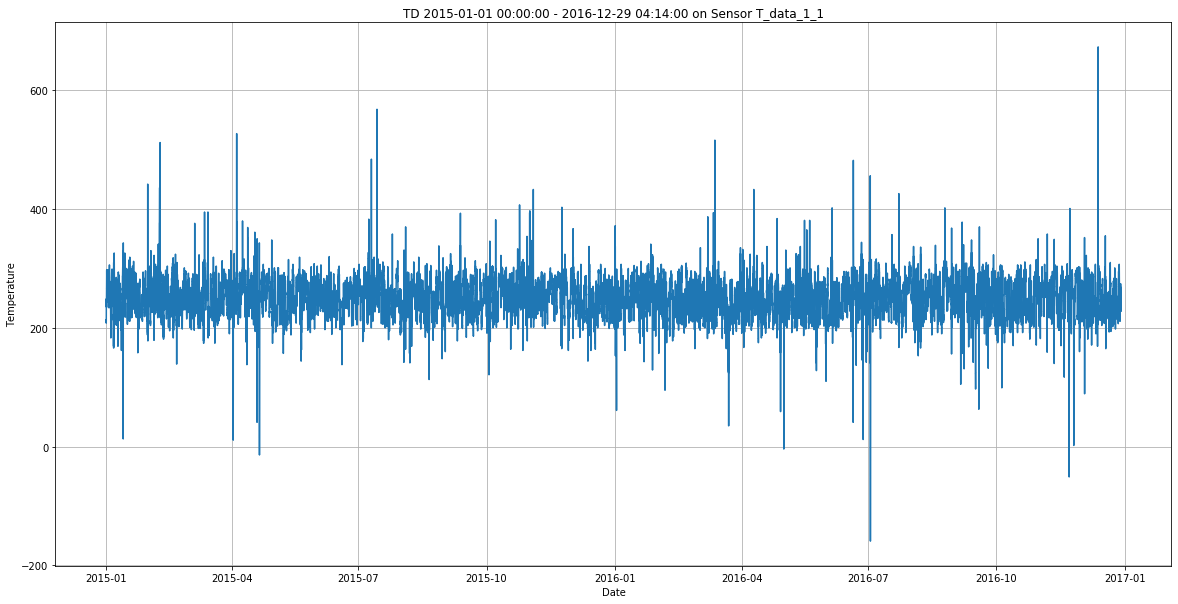

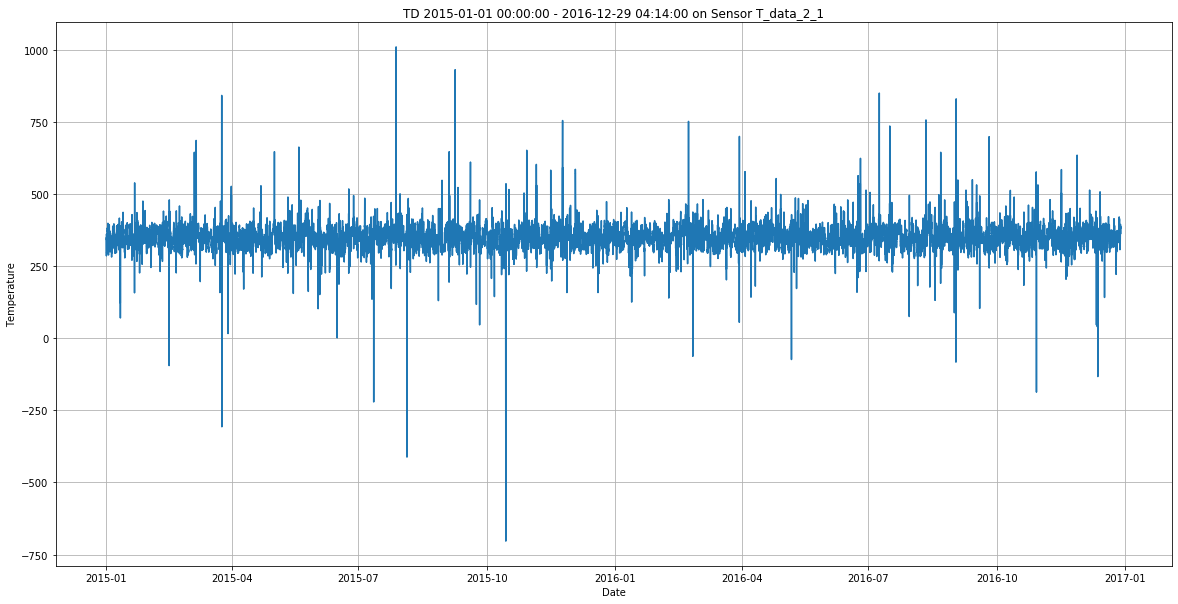

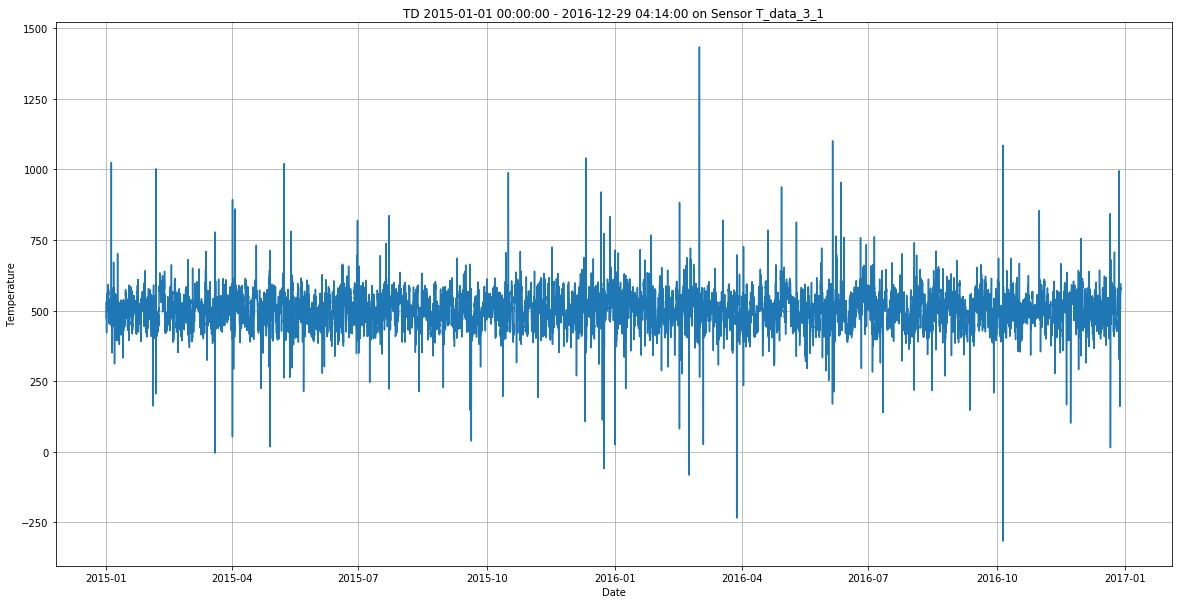

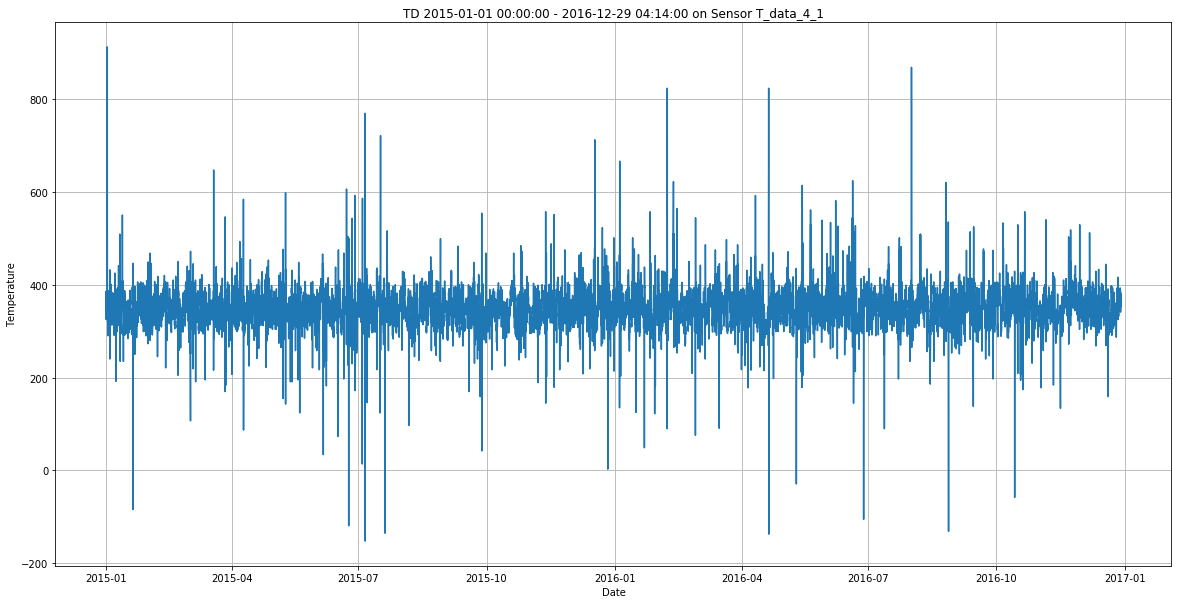

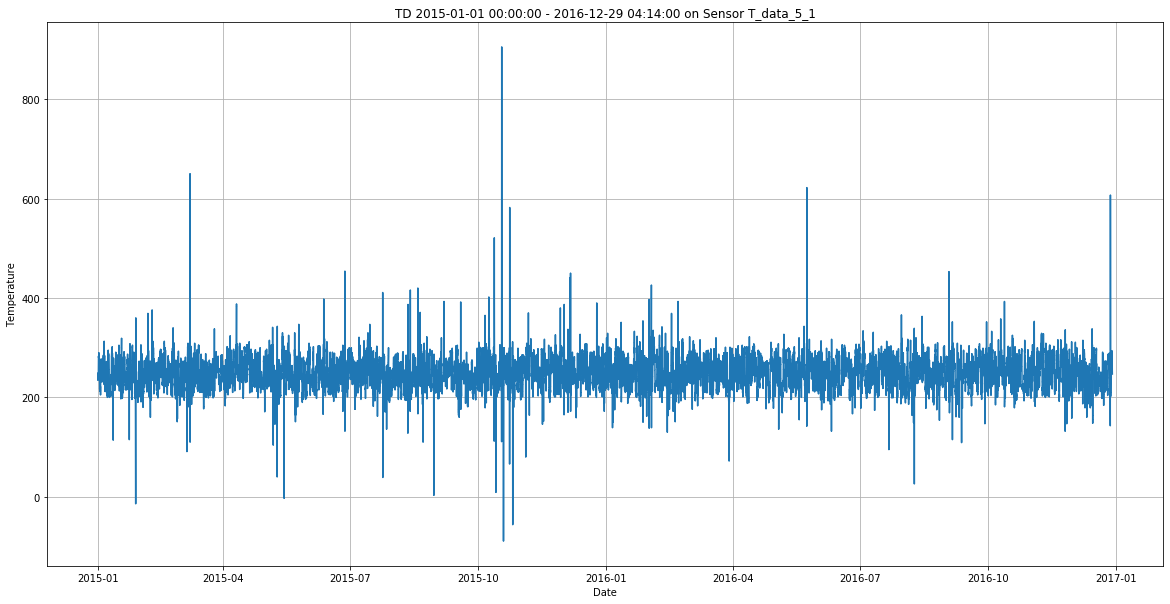

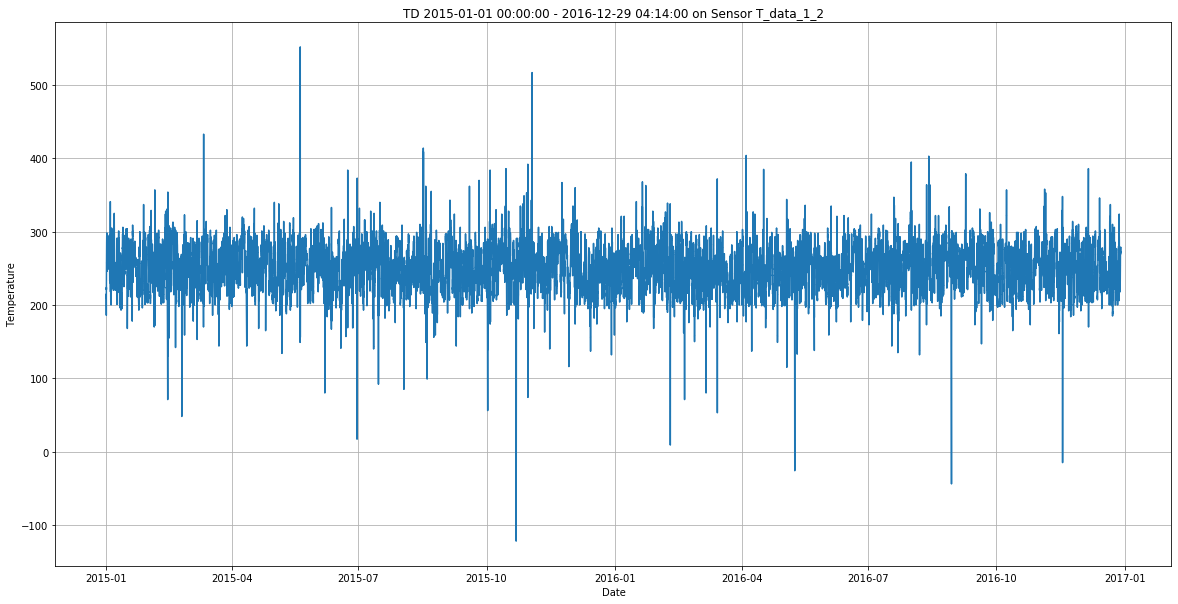

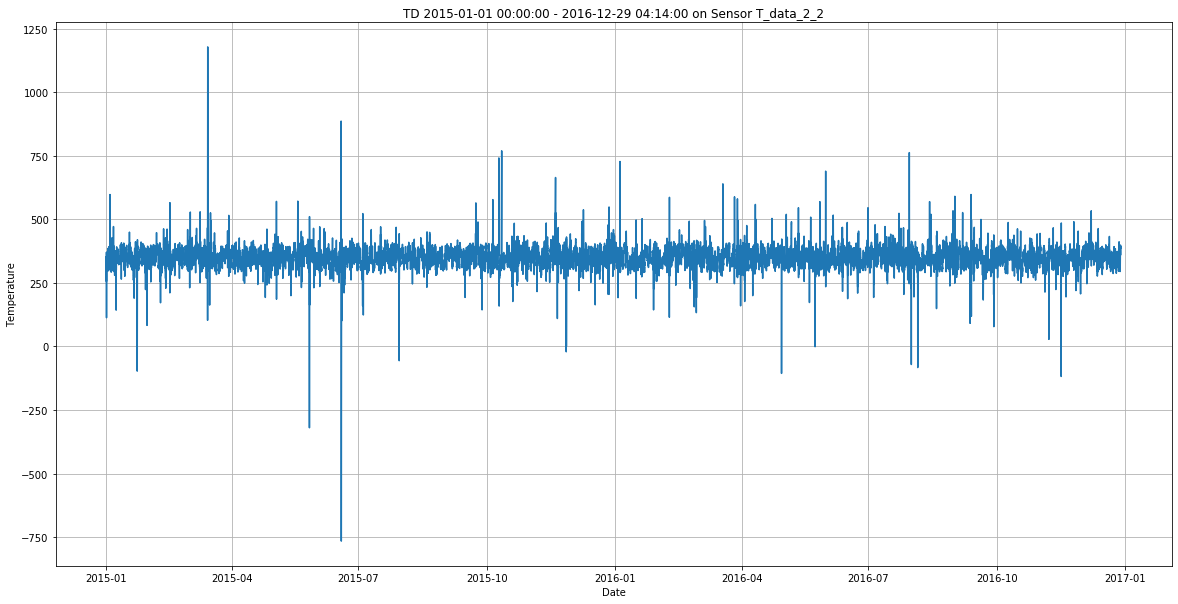

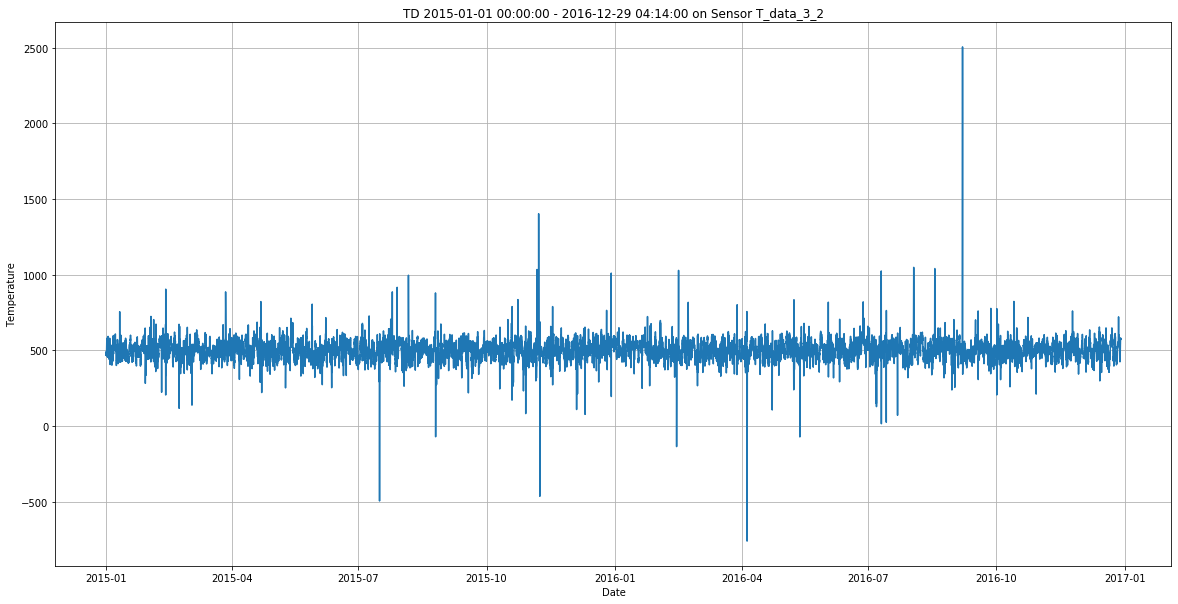

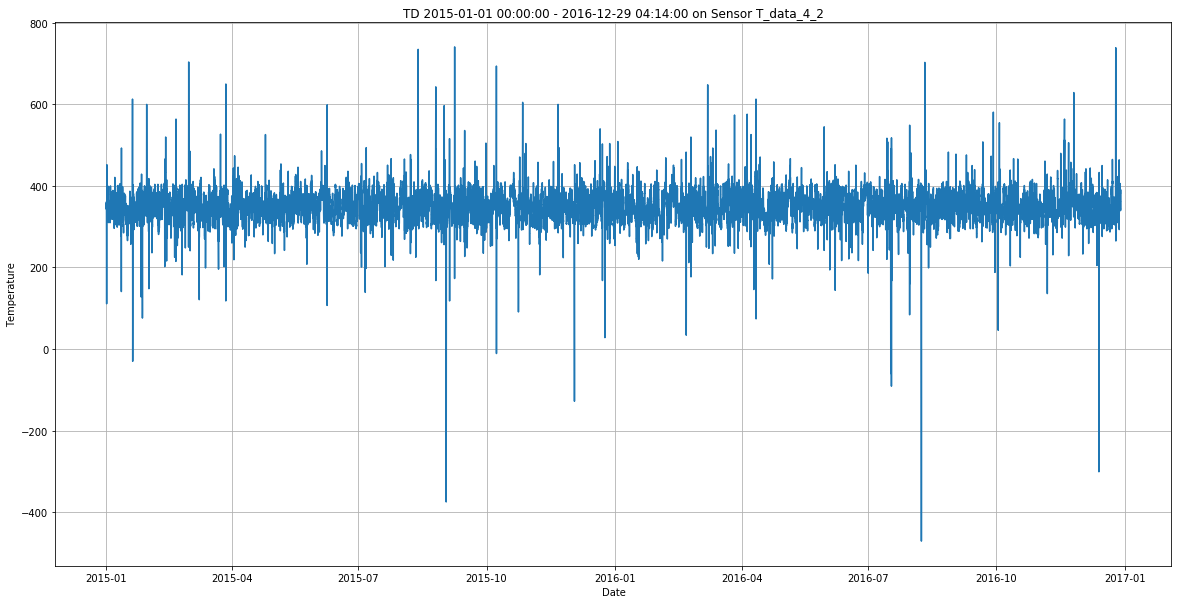

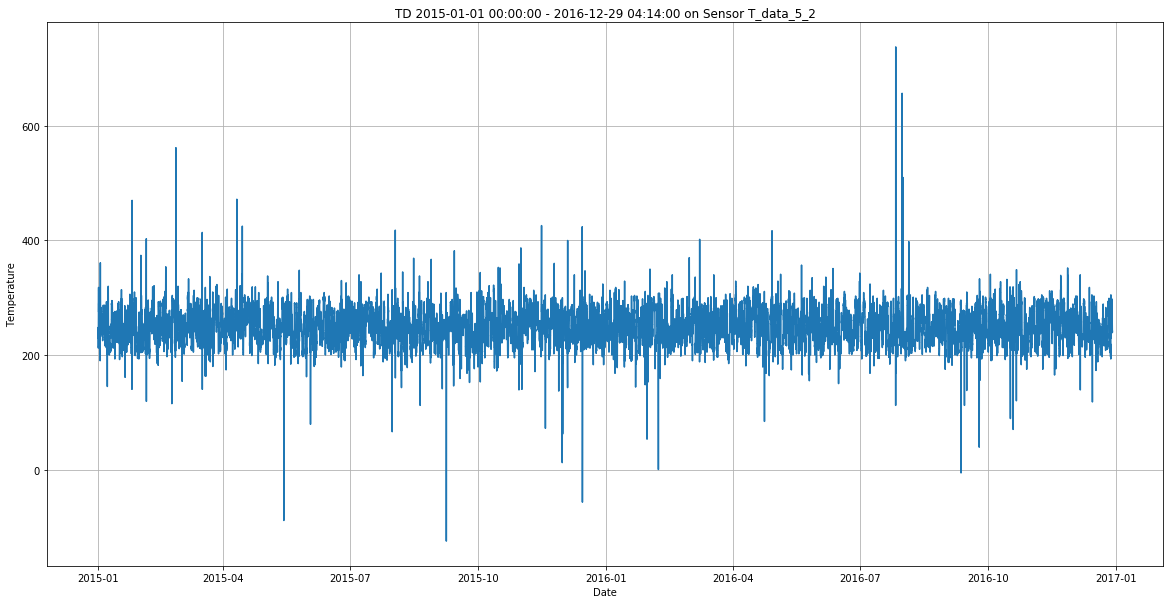

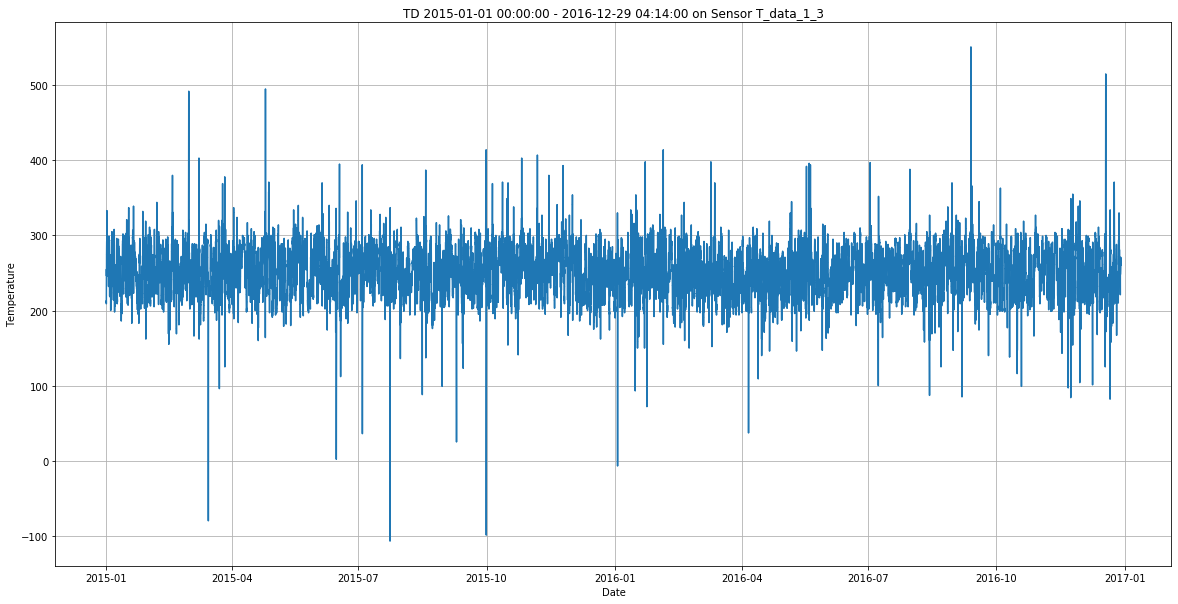

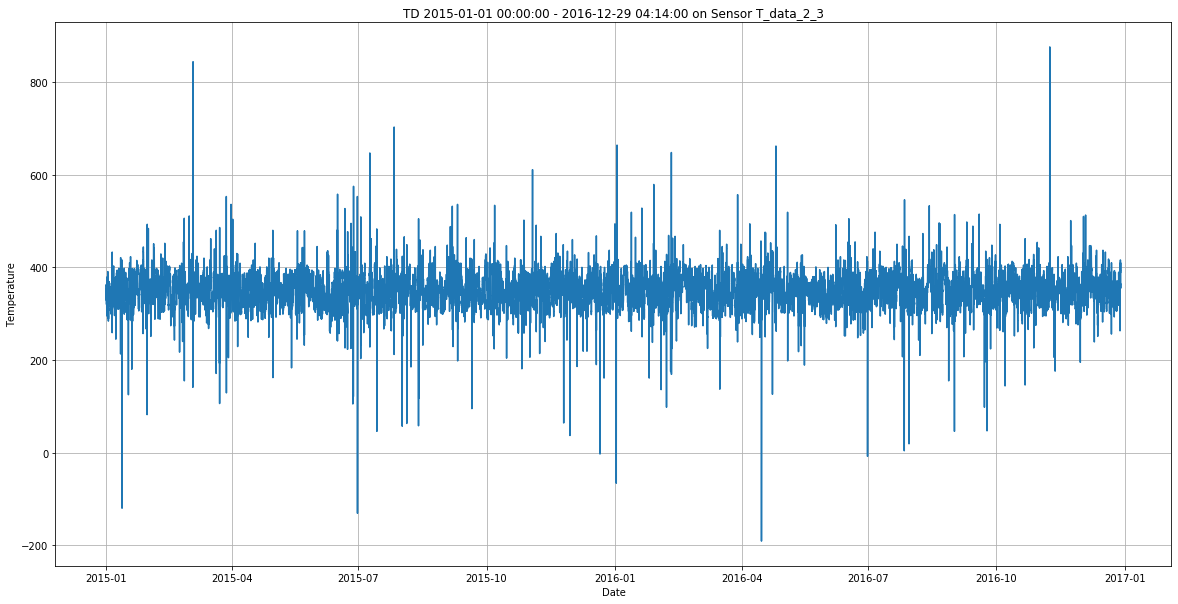

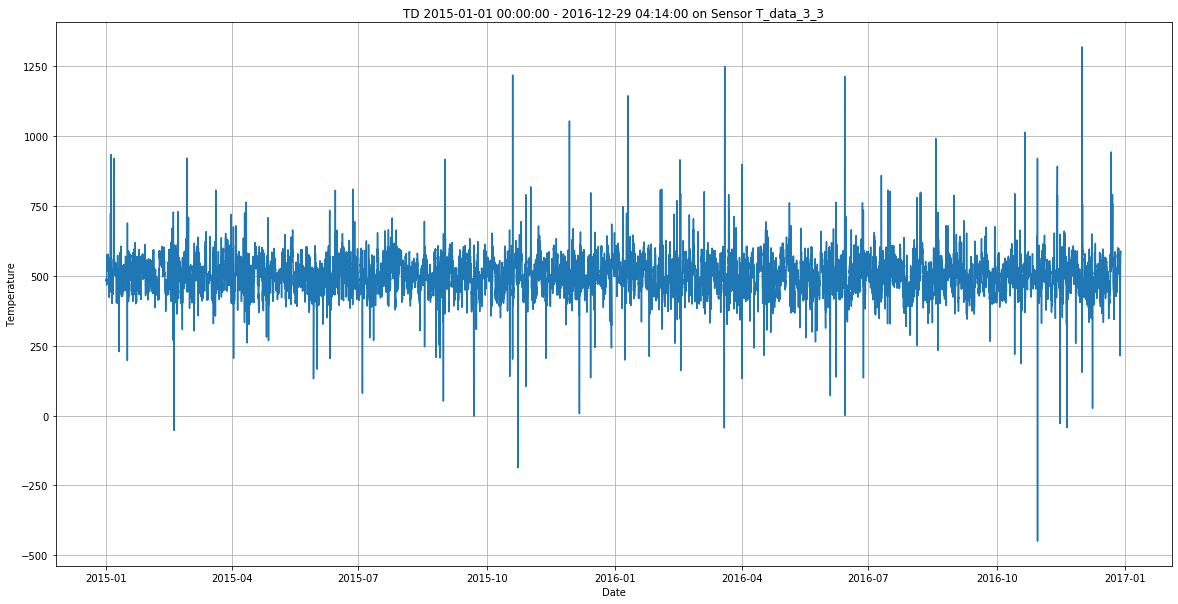

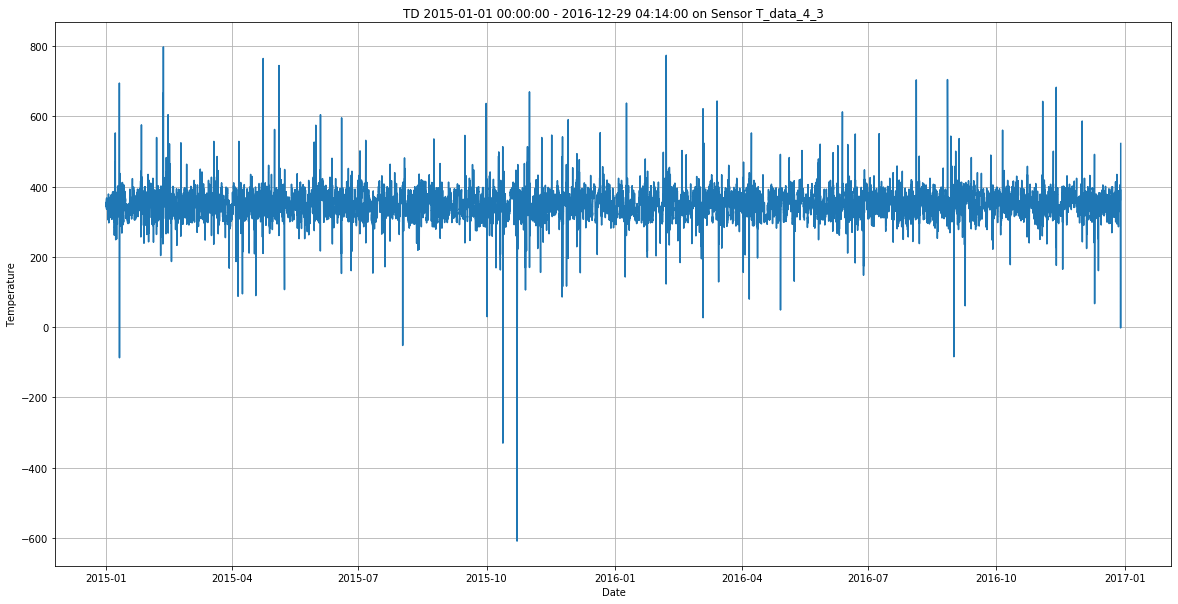

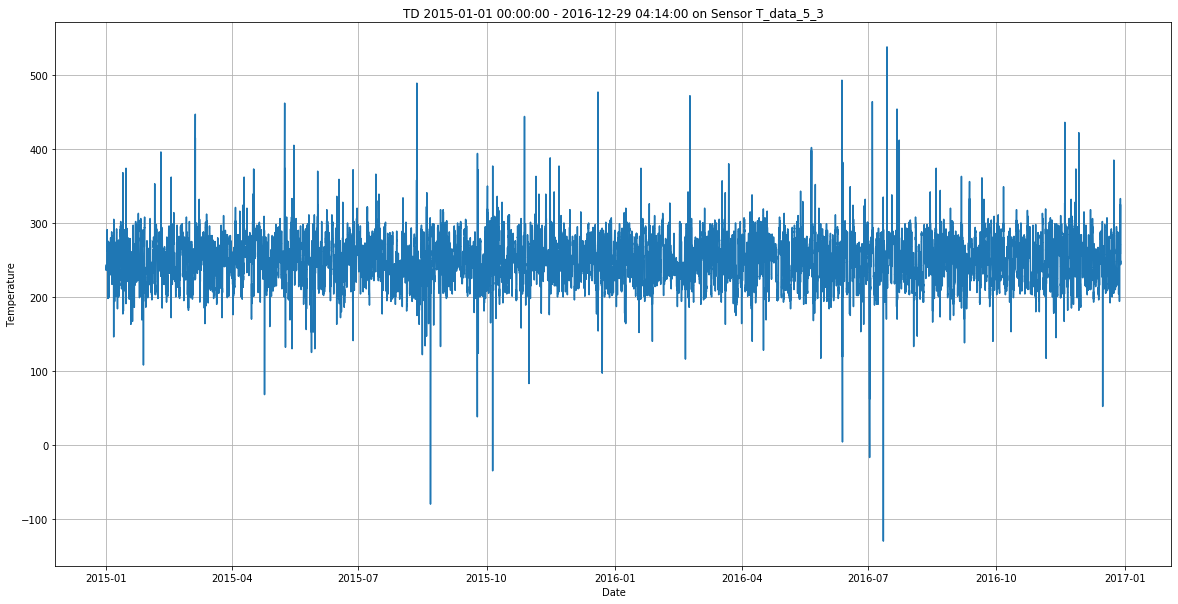

In [13]:
#temper_plt('T_data_1_1', date_min, date_max)
for i in range(1,4):
    for j in range(1,6):
        temper_plt('T_data_'+str(j)+'_'+str(i), date_min, date_max)

##### Видны значительные выбросы температуры, вплоть до -600 градусов, считаем все выбросы  - сбоем датчика

In [14]:
# Другая реализация функции для  вывода графика изменения температуры на датчике в определенном диапазоне дат/времени 
def temper_plt_2(sensor_name, date1, date2):
    sensor = df.loc[(df['OpTime'] >= date1) & (df['OpTime'] < date2), sensor_name]
    date = df.loc[(df['OpTime'] >= date1) & (df['OpTime'] < date2), 'OpTime'] 
    return sensor, date

In [15]:
keys = df.columns[1:-2] # Получим названия столбцов
keys

Index(['T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1', 'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3', 'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'T_data_5_1', 'T_data_5_2', 'T_data_5_3'], dtype='object')

In [16]:
date1 = '2015-11-29 00:00:00'
date2 = '2015-12-30 00:00:00'
delta_days = dt.datetime.strptime(date2, "%Y-%m-%d %H:%M:%S")-dt.datetime.strptime(date1, "%Y-%m-%d %H:%M:%S")
print('Посмотрим на изменение температуры на датчиках в диапазоне ', delta_days.days, 'дней ')

Посмотрим на изменение температуры на датчиках в диапазоне  31 дней 


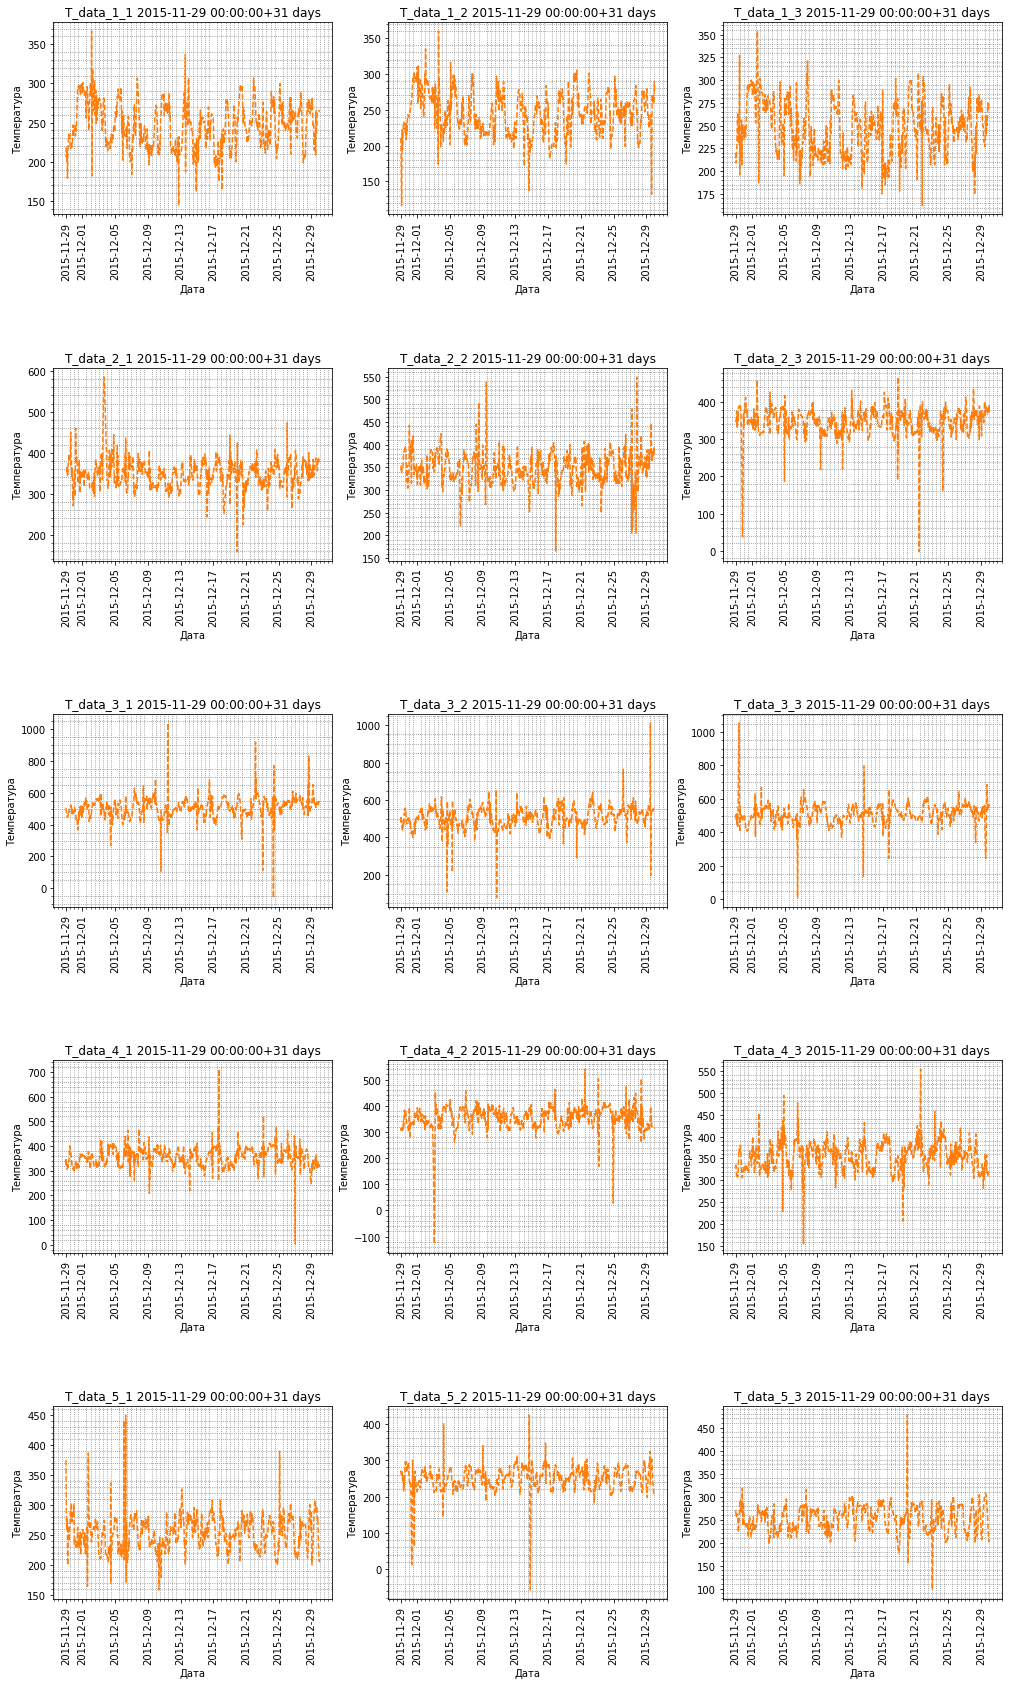

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=5)
fig.set_size_inches(17, 29)
plt.subplots_adjust(wspace=0.2, hspace=0.8)


for key, ax in zip(keys, axes.flatten()):
    y, x = temper_plt_2(key, date1, date2)
    delta = dt.datetime.strptime(date2, "%Y-%m-%d %H:%M:%S")-dt.datetime.strptime(date1, "%Y-%m-%d %H:%M:%S")
    ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               labelrotation = 90)    #  Поворот подписей
    ax.minorticks_on()
    ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
    ax.plot(x, y, color='C1', linestyle='dashed')
    
    ax.set_title(f'{key} {date1}+{delta.days} days')
    ax.set_xlabel('Дата')
    ax.set_ylabel('Температура')

In [18]:
median_=df.median(skipna = True)
median_

T_data_1_1   251.00
T_data_1_2   251.00
T_data_1_3   251.00
T_data_2_1   350.00
T_data_2_2   350.00
T_data_2_3   350.00
T_data_3_1   502.00
T_data_3_2   502.00
T_data_3_3   502.00
T_data_4_1   350.00
T_data_4_2   350.00
T_data_4_3   350.00
T_data_5_1   249.00
T_data_5_2   250.00
T_data_5_3   250.00
H_data       174.31
AH_data        7.52
dtype: float64

In [19]:
std_=df.std(skipna = True)
std_

T_data_1_1   31.26
T_data_1_2   30.17
T_data_1_3   30.75
T_data_2_1   44.28
T_data_2_2   40.83
T_data_2_3   37.22
T_data_3_1   60.11
T_data_3_2   67.03
T_data_3_3   62.08
T_data_4_1   38.84
T_data_4_2   38.78
T_data_4_3   40.85
T_data_5_1   30.81
T_data_5_2   30.34
T_data_5_3   29.72
H_data       14.42
AH_data       1.14
dtype: float64

In [20]:
mean_=df.mean(skipna = True)
mean_

T_data_1_1   250.84
T_data_1_2   250.36
T_data_1_3   250.81
T_data_2_1   349.89
T_data_2_2   349.92
T_data_2_3   349.69
T_data_3_1   501.52
T_data_3_2   501.51
T_data_3_3   501.84
T_data_4_1   349.42
T_data_4_2   349.42
T_data_4_3   350.24
T_data_5_1   249.57
T_data_5_2   249.74
T_data_5_3   249.70
H_data       174.54
AH_data        7.50
dtype: float64

### Построим распределение температры на датчиках

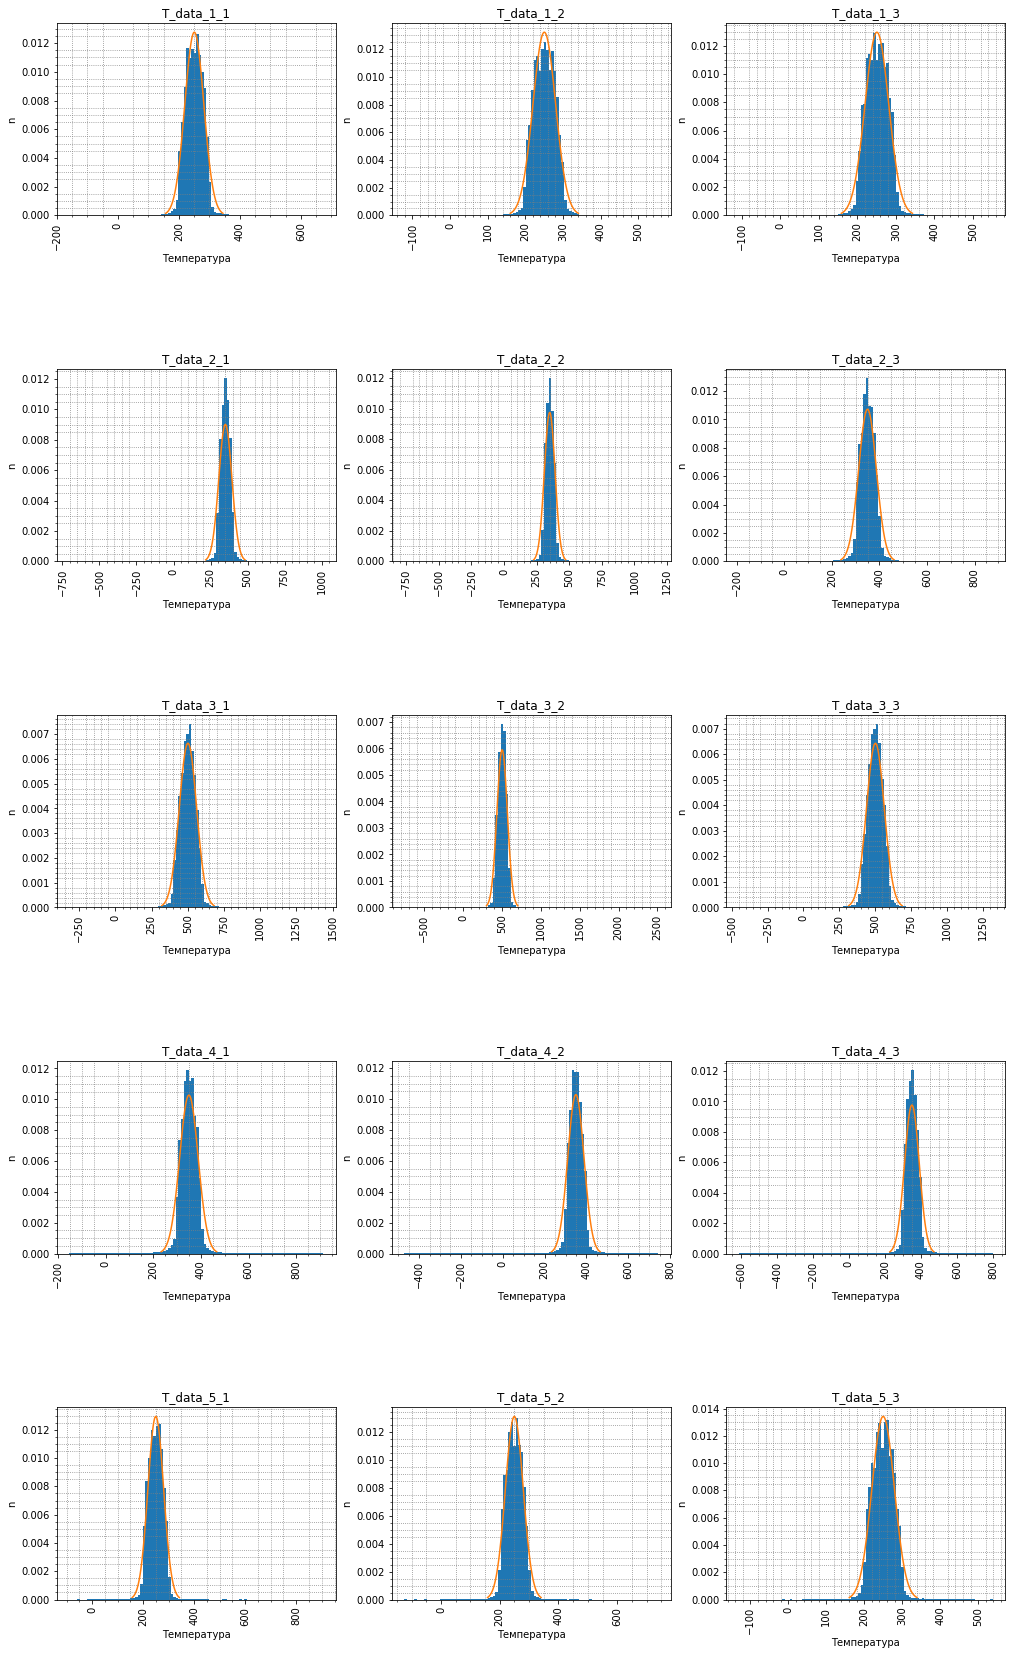

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=5)
fig.set_size_inches(17, 29)
plt.subplots_adjust(wspace=0.2, hspace=0.8)
for key, ax in zip(keys, axes.flatten()):
    sigma = std_[key]
    mu = mean_[key]
    ox = np.linspace(mu-3*sigma,mu+3*sigma,100)
    ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               labelrotation = 90)    #  Поворот подписей
    ax.minorticks_on()
    ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
    ax.hist(df[key], bins=100, density = True, label = 'hist') 
    ax.plot(ox, [norm.pdf(x, mu, sigma) for x in ox], label  = 'pdf')
    ax.set_title(key)
    ax.set_ylabel('n')
    ax.set_xlabel('Температура')

#### Все значения больше или меньше  $3 \cdot \sigma $ заменим на медиану.

In [22]:
df1 = df.copy()  # df1 -  этот датасет будем считать модифицированным 

In [23]:
for key in keys:
    df1.loc[(df1[key]>3*std_[key]+mean_[key]), key] =  median_[key]
    df1.loc[(df1[key]<-3*std_[key]+mean_[key]), key] =  median_[key]

##### Построим графики  распределений температуры еще раз

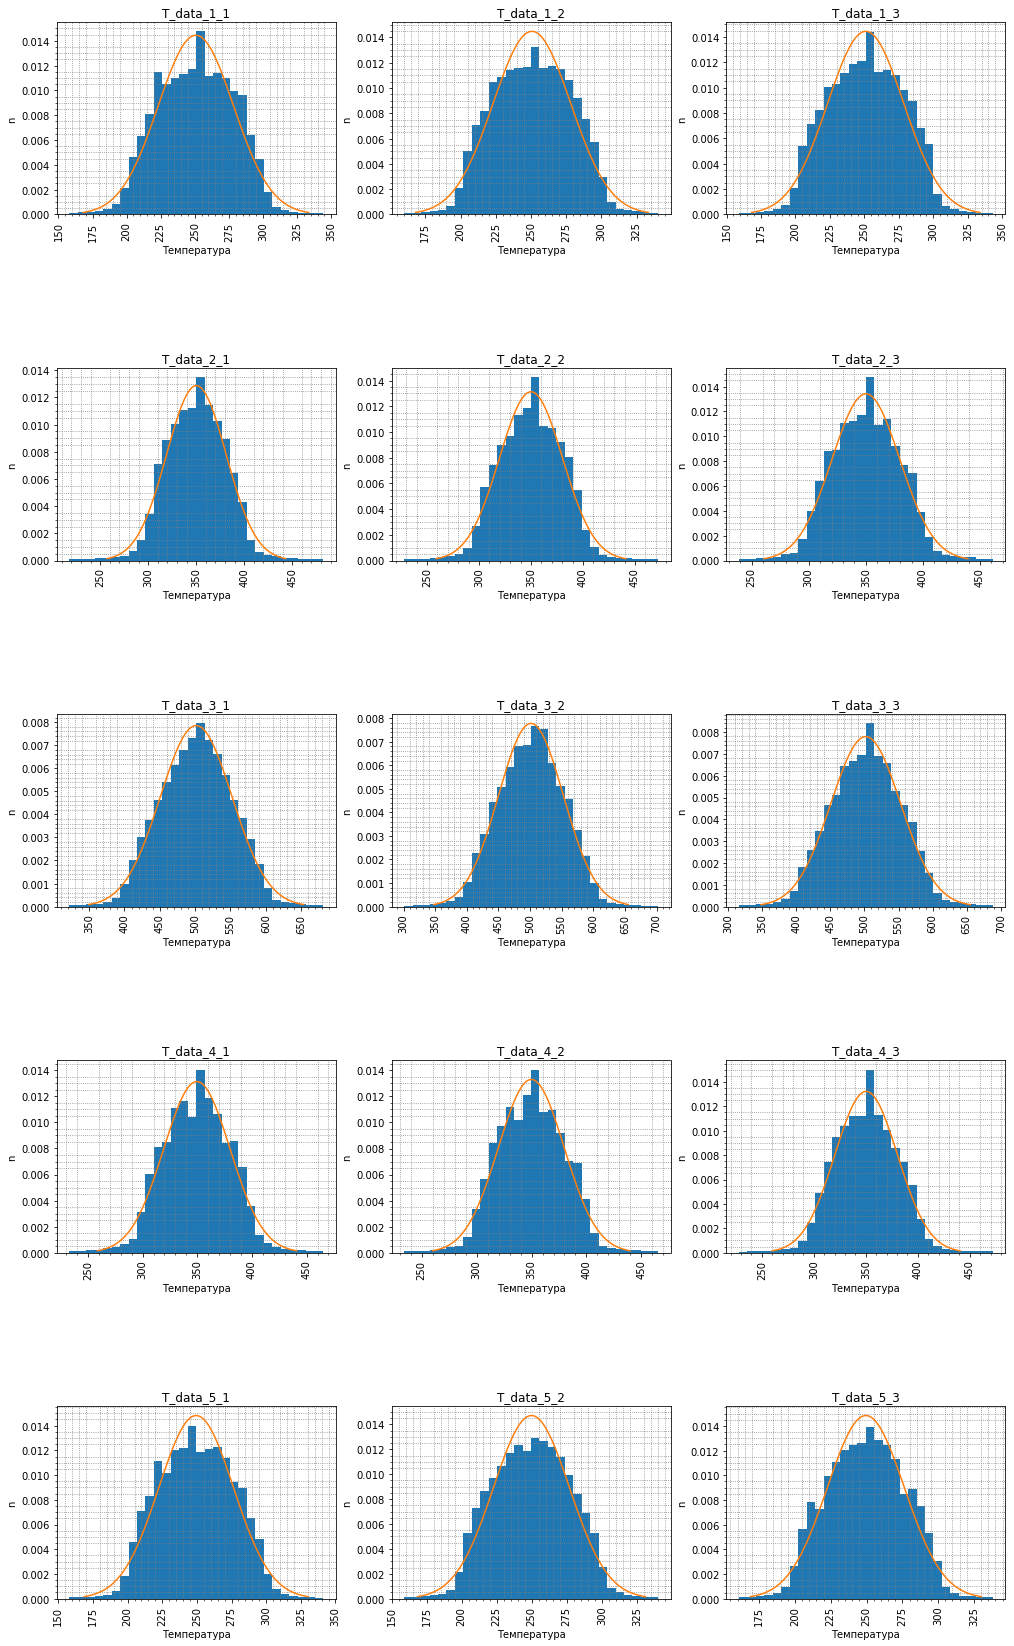

In [24]:
std_=df1.std(skipna = True)
mean_=df1.mean(skipna = True)

fig, axes = plt.subplots(ncols=3, nrows=5)
fig.set_size_inches(17, 29)
plt.subplots_adjust(wspace=0.2, hspace=0.8)
for key, ax in zip(keys, axes.flatten()):
    sigma = std_[key]
    mu = mean_[key]
    ox = np.linspace(mu-3*sigma,mu+3*sigma,100)
    ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               labelrotation = 90)    #  Поворот подписей
    ax.minorticks_on()
    ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
    ax.hist(df1[key], bins=30, density = True, label = 'hist') 
    ax.plot(ox, [norm.pdf(x, mu, sigma) for x in ox], label  = 'pdf')
    ax.set_title(key)
    ax.set_ylabel('n')
    ax.set_xlabel('Температура')    

### Изучим данные о влажности и высоте сырья

In [25]:
keys_res =  df.columns[-2:]
keys_res

Index(['H_data', 'AH_data'], dtype='object')

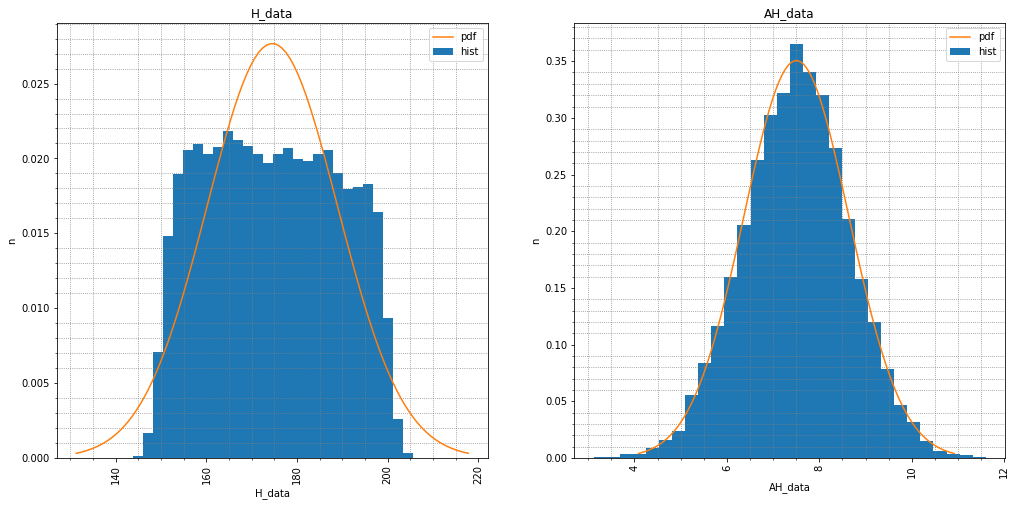

In [26]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(17, 8)
plt.subplots_adjust(wspace=0.2, hspace=0.8)
for key, ax in zip(keys_res, axes.flatten()):
    sigma = std_[key]
    mu = mean_[key]
    ox = np.linspace(mu-3*sigma,mu+3*sigma,100)
    ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               labelrotation = 90)    #  Поворот подписей
    ax.minorticks_on()
    ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
    ax.hist(df[key], bins=30, density = True, label = 'hist') 
    ax.plot(ox, [norm.pdf(x, mu, sigma) for x in ox], label  = 'pdf')
    ax.set_title(key)
    ax.set_ylabel('n')
    ax.set_xlabel(key)
    ax.legend()

#### Высота  - распределение близко к равномерному, влажность -  идеально похоже на нормальное.

### Загрузим данные о качестве

In [87]:
y_train= pd.read_csv('data/row/Y_train.csv', sep=';')

In [88]:
y_train.sample(3)

,DT,Qv
21554,20.06.2017 2:05,418
20368,01.05.2017 16:05,353
23193,27.08.2017 9:05,363


In [89]:
y_train['DT'] = pd.to_datetime(y_train['DT'], dayfirst=True)

In [90]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29184 entries, 0 to 29183
Data columns (total 2 columns):
DT    29184 non-null datetime64[ns]
Qv    29184 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 456.1 KB


In [91]:
y_train.describe()

,Qv
count,29184.00
mean,402.80
std,46.27
min,221.00
25%,372.00
50%,408.00
75%,439.00
max,505.00


In [92]:
dmax_yt = max(y_train['DT'])
dmin_yt = min(y_train['DT'])
print('Дата минимальная', dmin_yt, 'Дата максимальная', dmax_yt)

Дата минимальная 2015-01-04 00:05:00 Дата максимальная 2018-05-03 23:05:00


#### Посмотрим на распределение

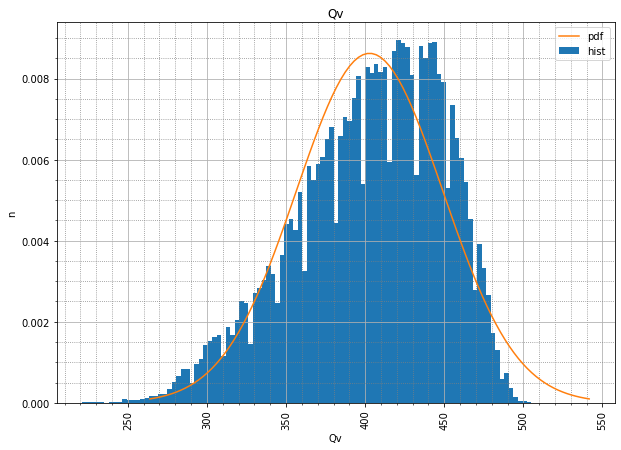

In [33]:
keys_yt  = y_train.columns[1:]
axes = y_train['Qv'].hist(bins=100, density = True, label = 'hist', figsize=(10, 7))
sigma =  y_train['Qv'].std()
mu = y_train['Qv'].mean()
ox = np.linspace(mu-3*sigma,mu+3*sigma,100)
axes.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               labelrotation = 90)    #  Поворот подписей
axes.minorticks_on()
axes.grid(which='minor',
        color = 'gray',
        linestyle = ':')
axes.plot(ox, [norm.pdf(x, mu, sigma) for x in ox], label  = 'pdf')
axes.set_title('Qv')
axes.set_ylabel('n')
axes.set_xlabel('Qv')
axes.legend()

#### Подготовим новый массив данных таким образом, что  все данные о температуре датчика с X:00 по  X:59 - усредняем по каждому датчику.

# Внимание!!!! Код ниже выполнется более 30 минут

In [34]:
%%time
x_train = pd.DataFrame(columns = df1.columns[1:])
x_train.insert(len(x_train.columns), "D1",  True)
x_train.insert(len(x_train.columns), "D2",  True)
d1 = df1['OpTime'][0]
i = 1
print('Всего записей', len(df1['OpTime']))
for dtp in df1['OpTime'][1:]:  # начинаем с :1 т.к. первую дату уже взяли в d1
    if dtp.minute == 59:
        d2 = df1['OpTime'][i]
        temp = df1.loc[(df1['OpTime'] >= d1) & (df1['OpTime'] <= d2),df1.columns]
        temp2 = temp.describe()
        temp2['D1'] = d1
        temp2['D2'] = d2
        new_rec = temp2.loc['mean']
        col = temp2.columns
        x_train = x_train.append(new_rec, ignore_index=True)
        #temp3 = temp.median()
        d1 = df1['OpTime'][i+1] 
    i +=1
    if i%10000==0:
        print('')
        print(f'обработано записей  {i} ')
    if i % 1000 == 0:
        print('-',end=' ')
    

Всего записей 1048575
- - - - - - - - - 
обработано записей  10000 
- - - - - - - - - - 
обработано записей  20000 
- - - - - - - - - - 
обработано записей  30000 
- - - - - - - - - - 
обработано записей  40000 
- - - - - - - - - - 
обработано записей  50000 
- - - - - - - - - - 
обработано записей  60000 
- - - - - - - - - - 
обработано записей  70000 
- - - - - - - - - - 
обработано записей  80000 
- - - - - - - - - - 
обработано записей  90000 
- - - - - - - - - - 
обработано записей  100000 
- - - - - - - - - - 
обработано записей  110000 
- - - - - - - - - - 
обработано записей  120000 
- - - - - - - - - - 
обработано записей  130000 
- - - - - - - - - - 
обработано записей  140000 
- - - - - - - - - - 
обработано записей  150000 
- - - - - - - - - - 
обработано записей  160000 
- - - - - - - - - - 
обработано записей  170000 
- - - - - - - - - - 
обработано записей  180000 
- - - - - - - - - - 
обработано записей  190000 
- - - - - - - - - - 
обработано записей  200000 
- - - - -

In [70]:
x_train

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,D1,D2
71,271.22,306.95,266.87,328.80,329.12,345.08,501.33,499.20,583.78,320.12,360.68,336.33,232.38,236.60,242.05,155.85,4.73,2015-01-03 23:00:00,2015-01-03 23:59:00
72,277.58,300.37,273.55,320.48,331.97,355.45,501.90,501.65,535.85,330.23,387.13,336.32,231.85,237.68,236.52,156.45,7.90,2015-01-04 00:00:00,2015-01-04 00:59:00
73,273.60,231.83,266.80,322.70,334.22,347.13,501.13,500.37,563.52,341.55,398.68,334.35,237.02,245.68,231.97,156.00,6.96,2015-01-04 01:00:00,2015-01-04 01:59:00
74,250.33,227.03,256.35,326.58,333.67,317.72,511.18,498.12,492.37,345.35,395.07,332.23,248.85,254.15,244.78,156.05,7.29,2015-01-04 02:00:00,2015-01-04 02:59:00
75,240.40,239.35,249.25,325.75,325.40,310.50,522.68,498.97,538.72,341.28,379.88,337.82,260.00,260.52,248.55,188.48,7.11,2015-01-04 03:00:00,2015-01-04 03:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17471,267.43,271.85,261.00,381.67,386.83,394.63,550.92,555.88,563.30,371.40,371.93,373.35,285.52,290.58,311.55,197.20,8.50,2016-12-28 23:00:00,2016-12-28 23:59:00
17472,265.57,271.27,263.48,382.20,388.82,404.65,564.93,573.42,573.80,349.60,356.65,303.98,281.25,284.33,284.60,196.59,5.98,2016-12-29 00:00:00,2016-12-29 00:59:00
17473,266.73,272.15,268.50,385.67,393.40,406.63,575.72,581.77,580.02,343.18,348.17,350.00,272.33,274.95,272.73,196.90,6.79,2016-12-29 01:00:00,2016-12-29 01:59:00
17474,268.83,276.73,261.97,382.78,384.85,387.75,579.52,580.85,583.78,361.30,343.08,350.00,259.95,256.53,262.37,196.49,7.14,2016-12-29 02:00:00,2016-12-29 02:59:00


In [71]:
x_train['D1'] = pd.to_datetime(x_train['D1'], dayfirst=True)
x_train['D2'] = pd.to_datetime(x_train['D2'], dayfirst=True)

In [72]:
x_train_copy = x_train.copy()
x_train.to_csv('x_train_copy.csv', index=False, sep=',', encoding='utf-8') # Сделаем копию массива данных

In [73]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17405 entries, 71 to 17475
Data columns (total 19 columns):
T_data_1_1    17405 non-null float64
T_data_1_2    17405 non-null float64
T_data_1_3    17405 non-null float64
T_data_2_1    17405 non-null float64
T_data_2_2    17405 non-null float64
T_data_2_3    17405 non-null float64
T_data_3_1    17405 non-null float64
T_data_3_2    17405 non-null float64
T_data_3_3    17405 non-null float64
T_data_4_1    17405 non-null float64
T_data_4_2    17405 non-null float64
T_data_4_3    17405 non-null float64
T_data_5_1    17405 non-null float64
T_data_5_2    17405 non-null float64
T_data_5_3    17405 non-null float64
H_data        17405 non-null float64
AH_data       17405 non-null float64
D1            17405 non-null datetime64[ns]
D2            17405 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(17)
memory usage: 2.7 MB


### Посмотим на распределение данных после их уплотнения

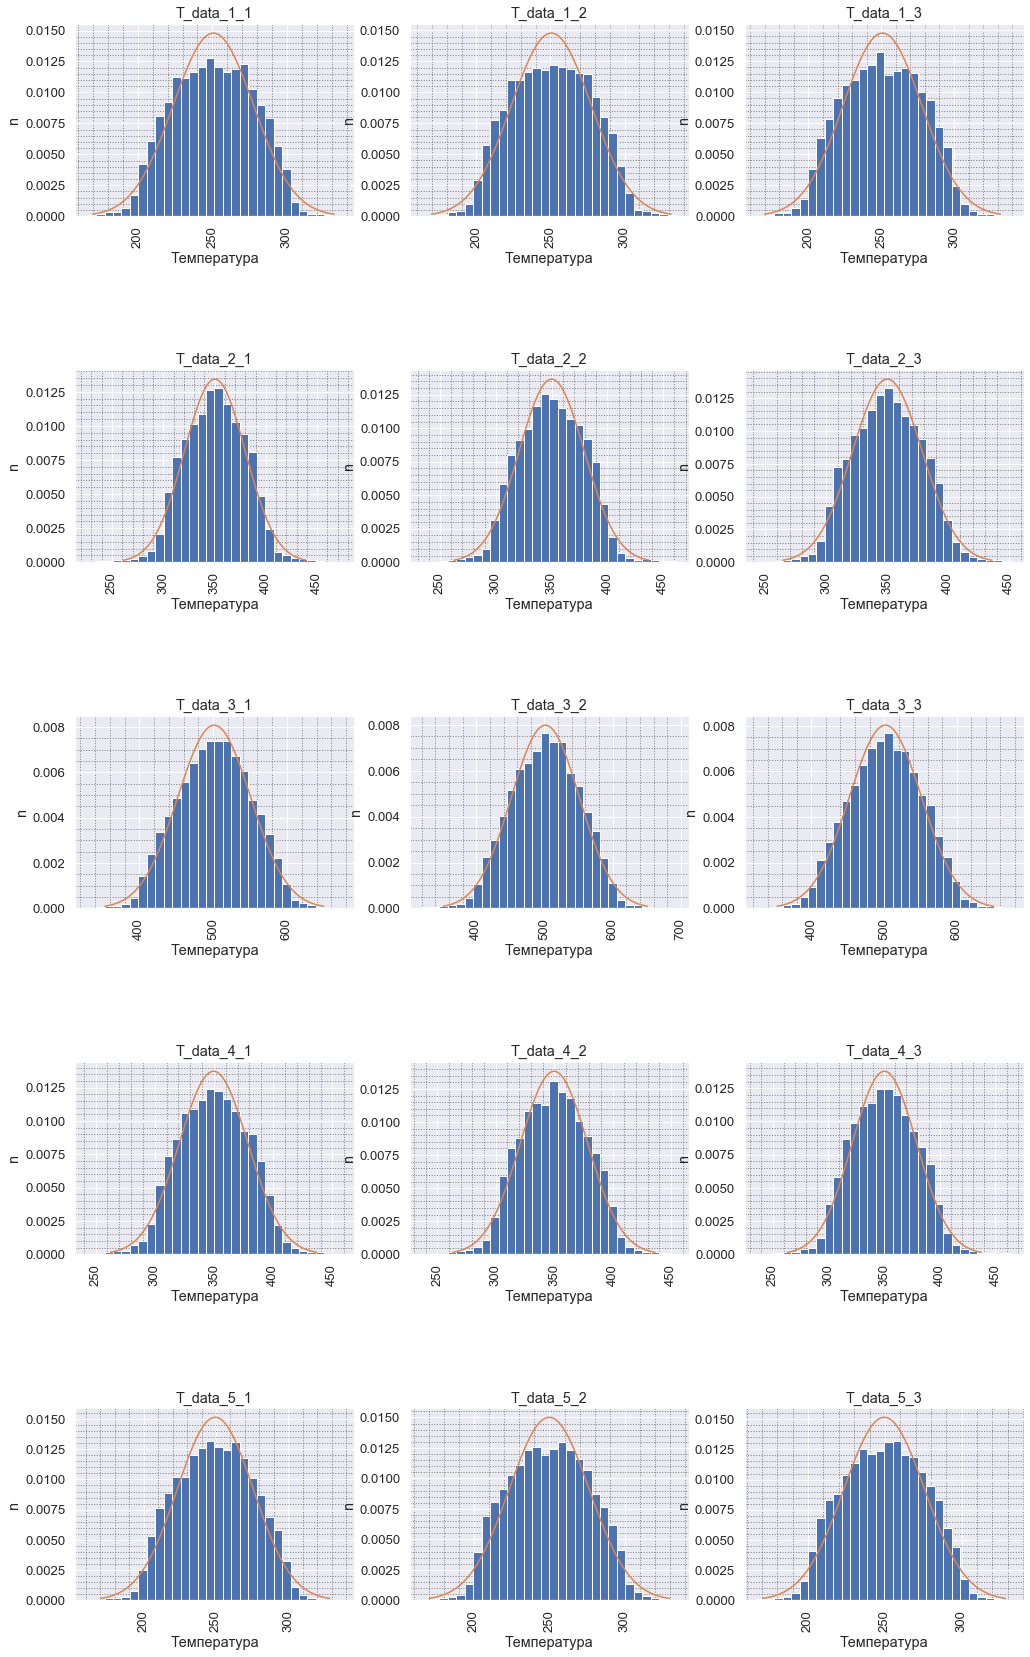

In [74]:
key_xt = x_train.columns[:-2]
std_=x_train.std(skipna = True)
mean_=x_train.mean(skipna = True)

fig, axes = plt.subplots(ncols=3, nrows=5)
fig.set_size_inches(17, 29)
plt.subplots_adjust(wspace=0.2, hspace=0.8)
for key, ax in zip(key_xt, axes.flatten()):
    sigma = std_[key]
    mu = mean_[key]
    ox = np.linspace(mu-3*sigma,mu+3*sigma,100)
    ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               labelrotation = 90)    #  Поворот подписей
    ax.minorticks_on()
    ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
    ax.hist(x_train[key], bins=30, density = True, label = 'hist') 
    ax.plot(ox, [norm.pdf(x, mu, sigma) for x in ox], label  = 'pdf')
    ax.set_title(key)
    ax.set_ylabel('n')
    ax.set_xlabel('Температура')   

In [75]:
len(y_train), len(x_train)

(17405, 17405)

### Код ниже выполняет сведение y_train и x_train по датам, следуя логике, что время X:05 - это  время когда было измерено качество продукции, которая проходила печите в предшествующий час '

In [93]:
y_train_copy = y_train.copy()
y_train.to_csv('y_train_copy.csv', index=False, sep=',', encoding='utf-8')

In [94]:
date_max_xt = max(x_train['D2'])
date_min_xt = min(x_train['D1'])
print(date_min_xt, date_max_xt)
date_max_yt = max(y_train['DT'])
date_min_yt = min(y_train['DT'])
print(date_min_yt, date_max_yt)


2015-01-03 23:00:00 2016-12-29 03:59:00
2015-01-04 00:05:00 2018-05-03 23:05:00


In [95]:
d_start_x = date_min_yt - dt.timedelta(minutes=65)
d_finish_x = date_max_xt
print(d_start_x, d_finish_x)

2015-01-03 23:00:00 2016-12-29 03:59:00


In [96]:
d_start_y = date_min_yt
d_finish_y = date_max_xt + dt.timedelta(minutes=6)
print(d_start_y, d_finish_y)

2015-01-04 00:05:00 2016-12-29 04:05:00


In [102]:
x_train = x_train.drop(np.where(x_train['D1'] < d_start_x)[0])
x_train = x_train.drop(np.where(x_train['D2'] > d_finish_x)[0])
x_train = x_train.reset_index()
x_train = x_train.drop('index',1)
x_train

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,D1,D2
0,271.22,306.95,266.87,328.80,329.12,345.08,501.33,499.20,583.78,320.12,360.68,336.33,232.38,236.60,242.05,155.85,4.73,2015-01-03 23:00:00,2015-01-03 23:59:00
1,277.58,300.37,273.55,320.48,331.97,355.45,501.90,501.65,535.85,330.23,387.13,336.32,231.85,237.68,236.52,156.45,7.90,2015-01-04 00:00:00,2015-01-04 00:59:00
2,273.60,231.83,266.80,322.70,334.22,347.13,501.13,500.37,563.52,341.55,398.68,334.35,237.02,245.68,231.97,156.00,6.96,2015-01-04 01:00:00,2015-01-04 01:59:00
3,250.33,227.03,256.35,326.58,333.67,317.72,511.18,498.12,492.37,345.35,395.07,332.23,248.85,254.15,244.78,156.05,7.29,2015-01-04 02:00:00,2015-01-04 02:59:00
4,240.40,239.35,249.25,325.75,325.40,310.50,522.68,498.97,538.72,341.28,379.88,337.82,260.00,260.52,248.55,188.48,7.11,2015-01-04 03:00:00,2015-01-04 03:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17400,267.43,271.85,261.00,381.67,386.83,394.63,550.92,555.88,563.30,371.40,371.93,373.35,285.52,290.58,311.55,197.20,8.50,2016-12-28 23:00:00,2016-12-28 23:59:00
17401,265.57,271.27,263.48,382.20,388.82,404.65,564.93,573.42,573.80,349.60,356.65,303.98,281.25,284.33,284.60,196.59,5.98,2016-12-29 00:00:00,2016-12-29 00:59:00
17402,266.73,272.15,268.50,385.67,393.40,406.63,575.72,581.77,580.02,343.18,348.17,350.00,272.33,274.95,272.73,196.90,6.79,2016-12-29 01:00:00,2016-12-29 01:59:00
17403,268.83,276.73,261.97,382.78,384.85,387.75,579.52,580.85,583.78,361.30,343.08,350.00,259.95,256.53,262.37,196.49,7.14,2016-12-29 02:00:00,2016-12-29 02:59:00


In [103]:
y_train = y_train.drop(np.where(y_train['DT'] < d_start_y)[0])
y_train = y_train.drop(np.where(y_train['DT'] > d_finish_y)[0])
y_train 

,DT,Qv
0,2015-01-04 00:05:00,392
1,2015-01-04 01:05:00,384
2,2015-01-04 02:05:00,393
3,2015-01-04 03:05:00,399
4,2015-01-04 04:05:00,400
...,...,...
17400,2016-12-29 00:05:00,404
17401,2016-12-29 01:05:00,395
17402,2016-12-29 02:05:00,377
17403,2016-12-29 03:05:00,368


In [104]:
len(y_train), len(x_train)

(17405, 17405)

In [105]:
train = x_train.copy()
col_tr=train.columns
train.insert(len(col_tr), "QV", y_train['Qv'], False)
train.insert(len(col_tr), "DT", y_train['DT'], False)
#train['DT'] = y_train['DT']
#train['Qv'] = y_train['Qv']
t_cols  = train.columns
t_cols_new = list(t_cols[17:21])+list(t_cols[0:17])
print(t_cols_new)
train = train[t_cols_new] 
#x_train.insert(len(x_train.columns), "D1",  True)
#x_train.insert(len(x_train.columns), "D2",  True)

['D1', 'D2', 'DT', 'QV', 'T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1', 'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3', 'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'T_data_5_1', 'T_data_5_2', 'T_data_5_3', 'H_data', 'AH_data']


In [106]:
train

,D1,D2,DT,QV,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,...,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-03 23:00:00,2015-01-03 23:59:00,2015-01-04 00:05:00,392,271.22,306.95,266.87,328.80,329.12,345.08,...,499.20,583.78,320.12,360.68,336.33,232.38,236.60,242.05,155.85,4.73
1,2015-01-04 00:00:00,2015-01-04 00:59:00,2015-01-04 01:05:00,384,277.58,300.37,273.55,320.48,331.97,355.45,...,501.65,535.85,330.23,387.13,336.32,231.85,237.68,236.52,156.45,7.90
2,2015-01-04 01:00:00,2015-01-04 01:59:00,2015-01-04 02:05:00,393,273.60,231.83,266.80,322.70,334.22,347.13,...,500.37,563.52,341.55,398.68,334.35,237.02,245.68,231.97,156.00,6.96
3,2015-01-04 02:00:00,2015-01-04 02:59:00,2015-01-04 03:05:00,399,250.33,227.03,256.35,326.58,333.67,317.72,...,498.12,492.37,345.35,395.07,332.23,248.85,254.15,244.78,156.05,7.29
4,2015-01-04 03:00:00,2015-01-04 03:59:00,2015-01-04 04:05:00,400,240.40,239.35,249.25,325.75,325.40,310.50,...,498.97,538.72,341.28,379.88,337.82,260.00,260.52,248.55,188.48,7.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17400,2016-12-28 23:00:00,2016-12-28 23:59:00,2016-12-29 00:05:00,404,267.43,271.85,261.00,381.67,386.83,394.63,...,555.88,563.30,371.40,371.93,373.35,285.52,290.58,311.55,197.20,8.50
17401,2016-12-29 00:00:00,2016-12-29 00:59:00,2016-12-29 01:05:00,395,265.57,271.27,263.48,382.20,388.82,404.65,...,573.42,573.80,349.60,356.65,303.98,281.25,284.33,284.60,196.59,5.98
17402,2016-12-29 01:00:00,2016-12-29 01:59:00,2016-12-29 02:05:00,377,266.73,272.15,268.50,385.67,393.40,406.63,...,581.77,580.02,343.18,348.17,350.00,272.33,274.95,272.73,196.90,6.79
17403,2016-12-29 02:00:00,2016-12-29 02:59:00,2016-12-29 03:05:00,368,268.83,276.73,261.97,382.78,384.85,387.75,...,580.85,583.78,361.30,343.08,350.00,259.95,256.53,262.37,196.49,7.14


In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17405 entries, 0 to 17404
Data columns (total 21 columns):
D1            17405 non-null datetime64[ns]
D2            17405 non-null datetime64[ns]
DT            17405 non-null datetime64[ns]
QV            17405 non-null int64
T_data_1_1    17405 non-null float64
T_data_1_2    17405 non-null float64
T_data_1_3    17405 non-null float64
T_data_2_1    17405 non-null float64
T_data_2_2    17405 non-null float64
T_data_2_3    17405 non-null float64
T_data_3_1    17405 non-null float64
T_data_3_2    17405 non-null float64
T_data_3_3    17405 non-null float64
T_data_4_1    17405 non-null float64
T_data_4_2    17405 non-null float64
T_data_4_3    17405 non-null float64
T_data_5_1    17405 non-null float64
T_data_5_2    17405 non-null float64
T_data_5_3    17405 non-null float64
H_data        17405 non-null float64
AH_data       17405 non-null float64
dtypes: datetime64[ns](3), float64(17), int64(1)
memory usage: 2.8 MB


Построим корреляцию

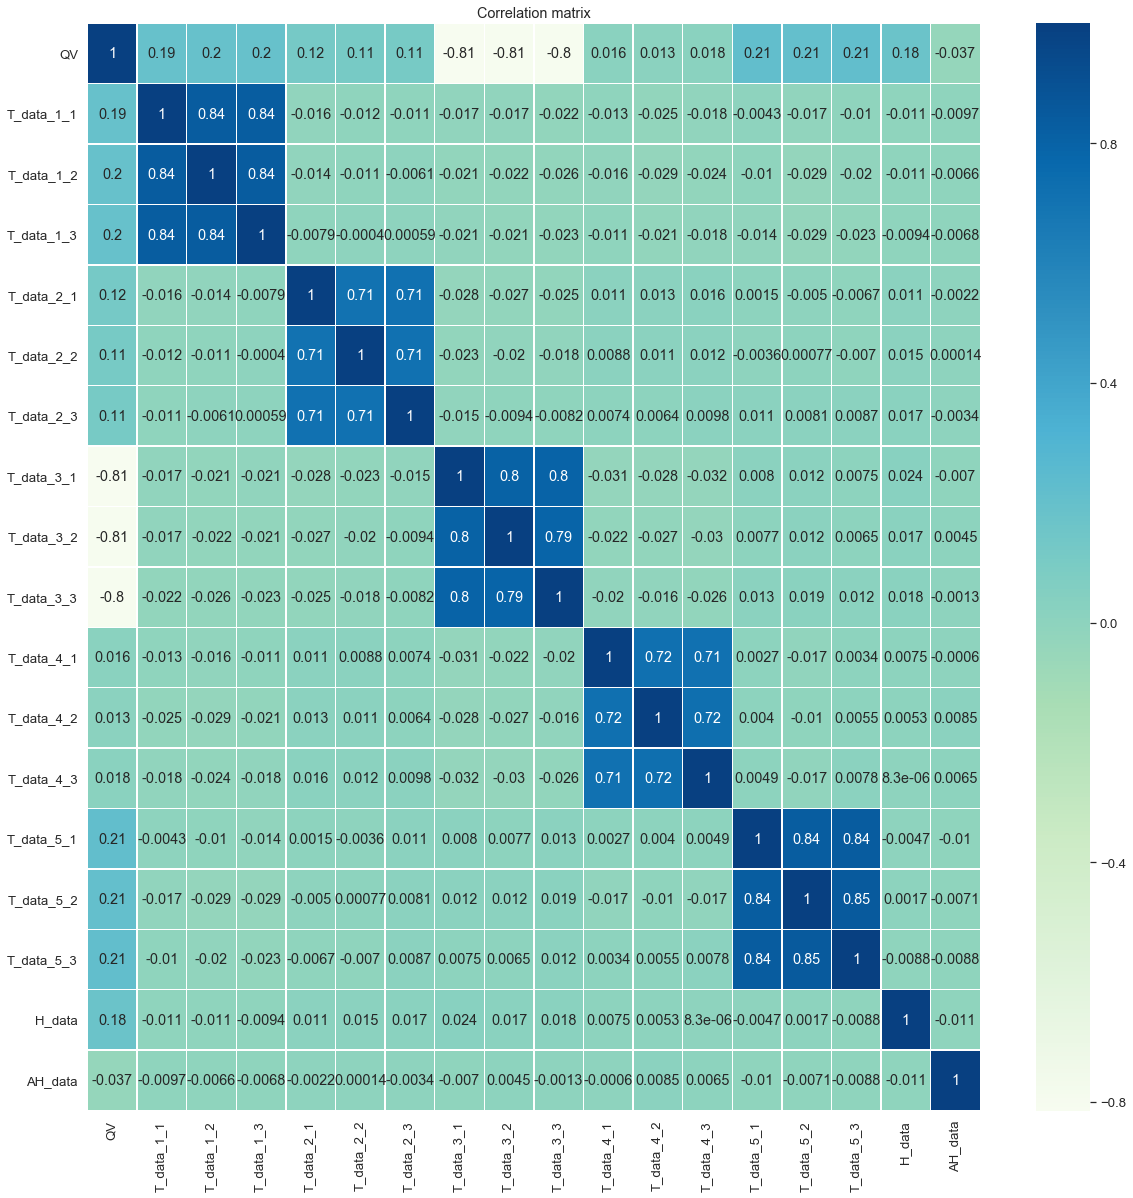

In [108]:
plt.figure(figsize = (20,20))
sns.set(font_scale=1.2)
sns.heatmap(train.corr(), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

In [109]:
train.to_csv('train_final.csv', index=False, sep=';', encoding='utf-8')

## Далее см. часть 2